# 第6回課題
前処理と特徴量選択により，SVM の最初のスコアよりも1割程度良いテストスコアを出してください．
ちょこっといじった程度では，線形回帰はスコアが変わらなかったので，参考程度に使ってください

### 必須事項
- 前処理：正規化，標準化，外れ値の排除など
- 特徴量選択: 検証は必須．増やす・減らす・変えないの結果は自由
- テストスコアの向上: mse で 0.41 くらいは出ると思います

### 自由事項
- 指標の変更
- パラメータの変更（モデルの変更は想定してません）

### 余談
特徴量選択で正解を用意するのは，やはり難しいなと解答を作る時に感じました．解答の方は最低限の考察と検証をしていますが，4時間かかりました( ;∀;)

## 注意事項
特徴量の分析時に分割したデータを使ってない時点でせこいというか，おかしいです．ここでは無視していますが，本来はできません．

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

For more information, read [Cortez et al., 2009].
Input variables (based on physicochemical tests):

- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

Output variable (based on sensory data):
- quality (score between 0 and 10)

In [3]:
wine_quality_df = pd.read_csv("winequality-red.csv",delimiter=";")
print(wine_quality_df.shape)
wine_quality_df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
wine_quality_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
feature_names = list(np.copy(wine_quality_df.columns))
feature_names.remove("quality")

In [6]:
X_train, X_test, y_train, y_test = \
    train_test_split(wine_quality_df[feature_names], wine_quality_df["quality"], 
                     test_size=0.3, random_state=0)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## 注意
ここで，test score まで同時に出してしまっているんですが，1つの関数で実行してしまう方が楽だったという理由だけで，これらは分けた方が良いです．
パラメータや特徴量について考えるときには，CV だけで調整すべきです

In [7]:
kfold = KFold(n_splits=5, random_state=0)
def cross_validation(model, test=True):
    global X_train, X_test, y_train, y_test, feature_names
    scores = cross_val_score(model, X_train[feature_names], y_train, cv=kfold, 
                             scoring=make_scorer(mean_squared_error))
    # 各分割におけるスコア
    print('Cross-Validation scores: {}'.format(scores))
    # スコアの平均値
    print('Average score: {}'.format(np.mean(scores)))
    if test:
        model.fit(X_train[feature_names], y_train)
        pred = model.predict(X_test[feature_names])
        print('Test score: {}'.format(mean_squared_error(y_test, pred)))

# モデルによる予測

In [8]:
linear_reg = Ridge(random_state=0)
cross_validation(linear_reg)

Cross-Validation scores: [0.48812538 0.48841541 0.42327305 0.42566563 0.36728215]
Average score: 0.43855232598926497
Test score: 0.4010466305154149


In [9]:
svm_clf = SVC(kernel="rbf", random_state=0)
cross_validation(svm_clf)

Cross-Validation scores: [0.67857143 0.82142857 0.71428571 0.75446429 0.62780269]
Average score: 0.719310538116592
Test score: 0.68125


In [10]:
svm_reg = SVR(kernel="rbf")
cross_validation(svm_reg)

Cross-Validation scores: [0.5715145  0.68175944 0.57909369 0.61098986 0.50245379]
Average score: 0.5891622546486783
Test score: 0.5085468469038228


# 以降にコードを追加

## 正規化

In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
# cross_validation 関数を利用するため、変数名はそのままで上書き
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

## 外れ値の排除
MATLABの外れ値検出方法 (https://jp.mathworks.com/help/matlab/ref/isoutlier.html) を参考に、
中央絶対偏差の3倍離れている値を外れ値として扱ってみる。

In [13]:
def median_absolute_derivation(col):
    return (col-col.median()).abs().median()

def outlier(col, n):
    # 外れ値ならTrue、 他Falseの配列を返す。
    # nが大きいほど外れ値となる値は少なくなる。
    return (col.median() - col).abs() > n * median_absolute_derivation(col)

In [14]:
# 3倍だと外れ値があまりにも多い
for col in X_train.columns:
    out_row = outlier(X_train[col], 3)
    print(X_train[out_row].shape[0])

103
48
5
158
143
74
127
89
56
99
86


In [15]:
# この方法では列ごとに n の値を変える必要がありそうだが、調節して浮かび出たデータが外れ値と言えるのか疑問が残るため断念。
for col in X_train.columns:
    out_row = outlier(X_train[col], 10)
    print(X_train[out_row].shape[0])

0
0
0
53
34
0
2
0
0
8
0


## スコア
正規化を行っただけで線形回帰以外はだいぶスコアの向上が見られた

In [16]:
cross_validation(linear_reg)

Cross-Validation scores: [0.4892121  0.48830701 0.42580411 0.42564279 0.36217685]
Average score: 0.4382285727903389
Test score: 0.4492016440328416


In [17]:
cross_validation(svm_clf)

Cross-Validation scores: [0.55803571 0.51785714 0.52232143 0.54910714 0.4529148 ]
Average score: 0.5200472453555414
Test score: 0.5145833333333333


In [18]:
cross_validation(svm_reg)

Cross-Validation scores: [0.4538687  0.42541329 0.38508794 0.43251404 0.3540613 ]
Average score: 0.4101890514465902
Test score: 0.436649611258576


## 特徴量選択
目的変数との相関の弱い特徴量は重要でないと仮定

他の特徴量との相関の強い特徴量は、他の特徴量で説明できるため重要でないと仮定（多重共線性？）

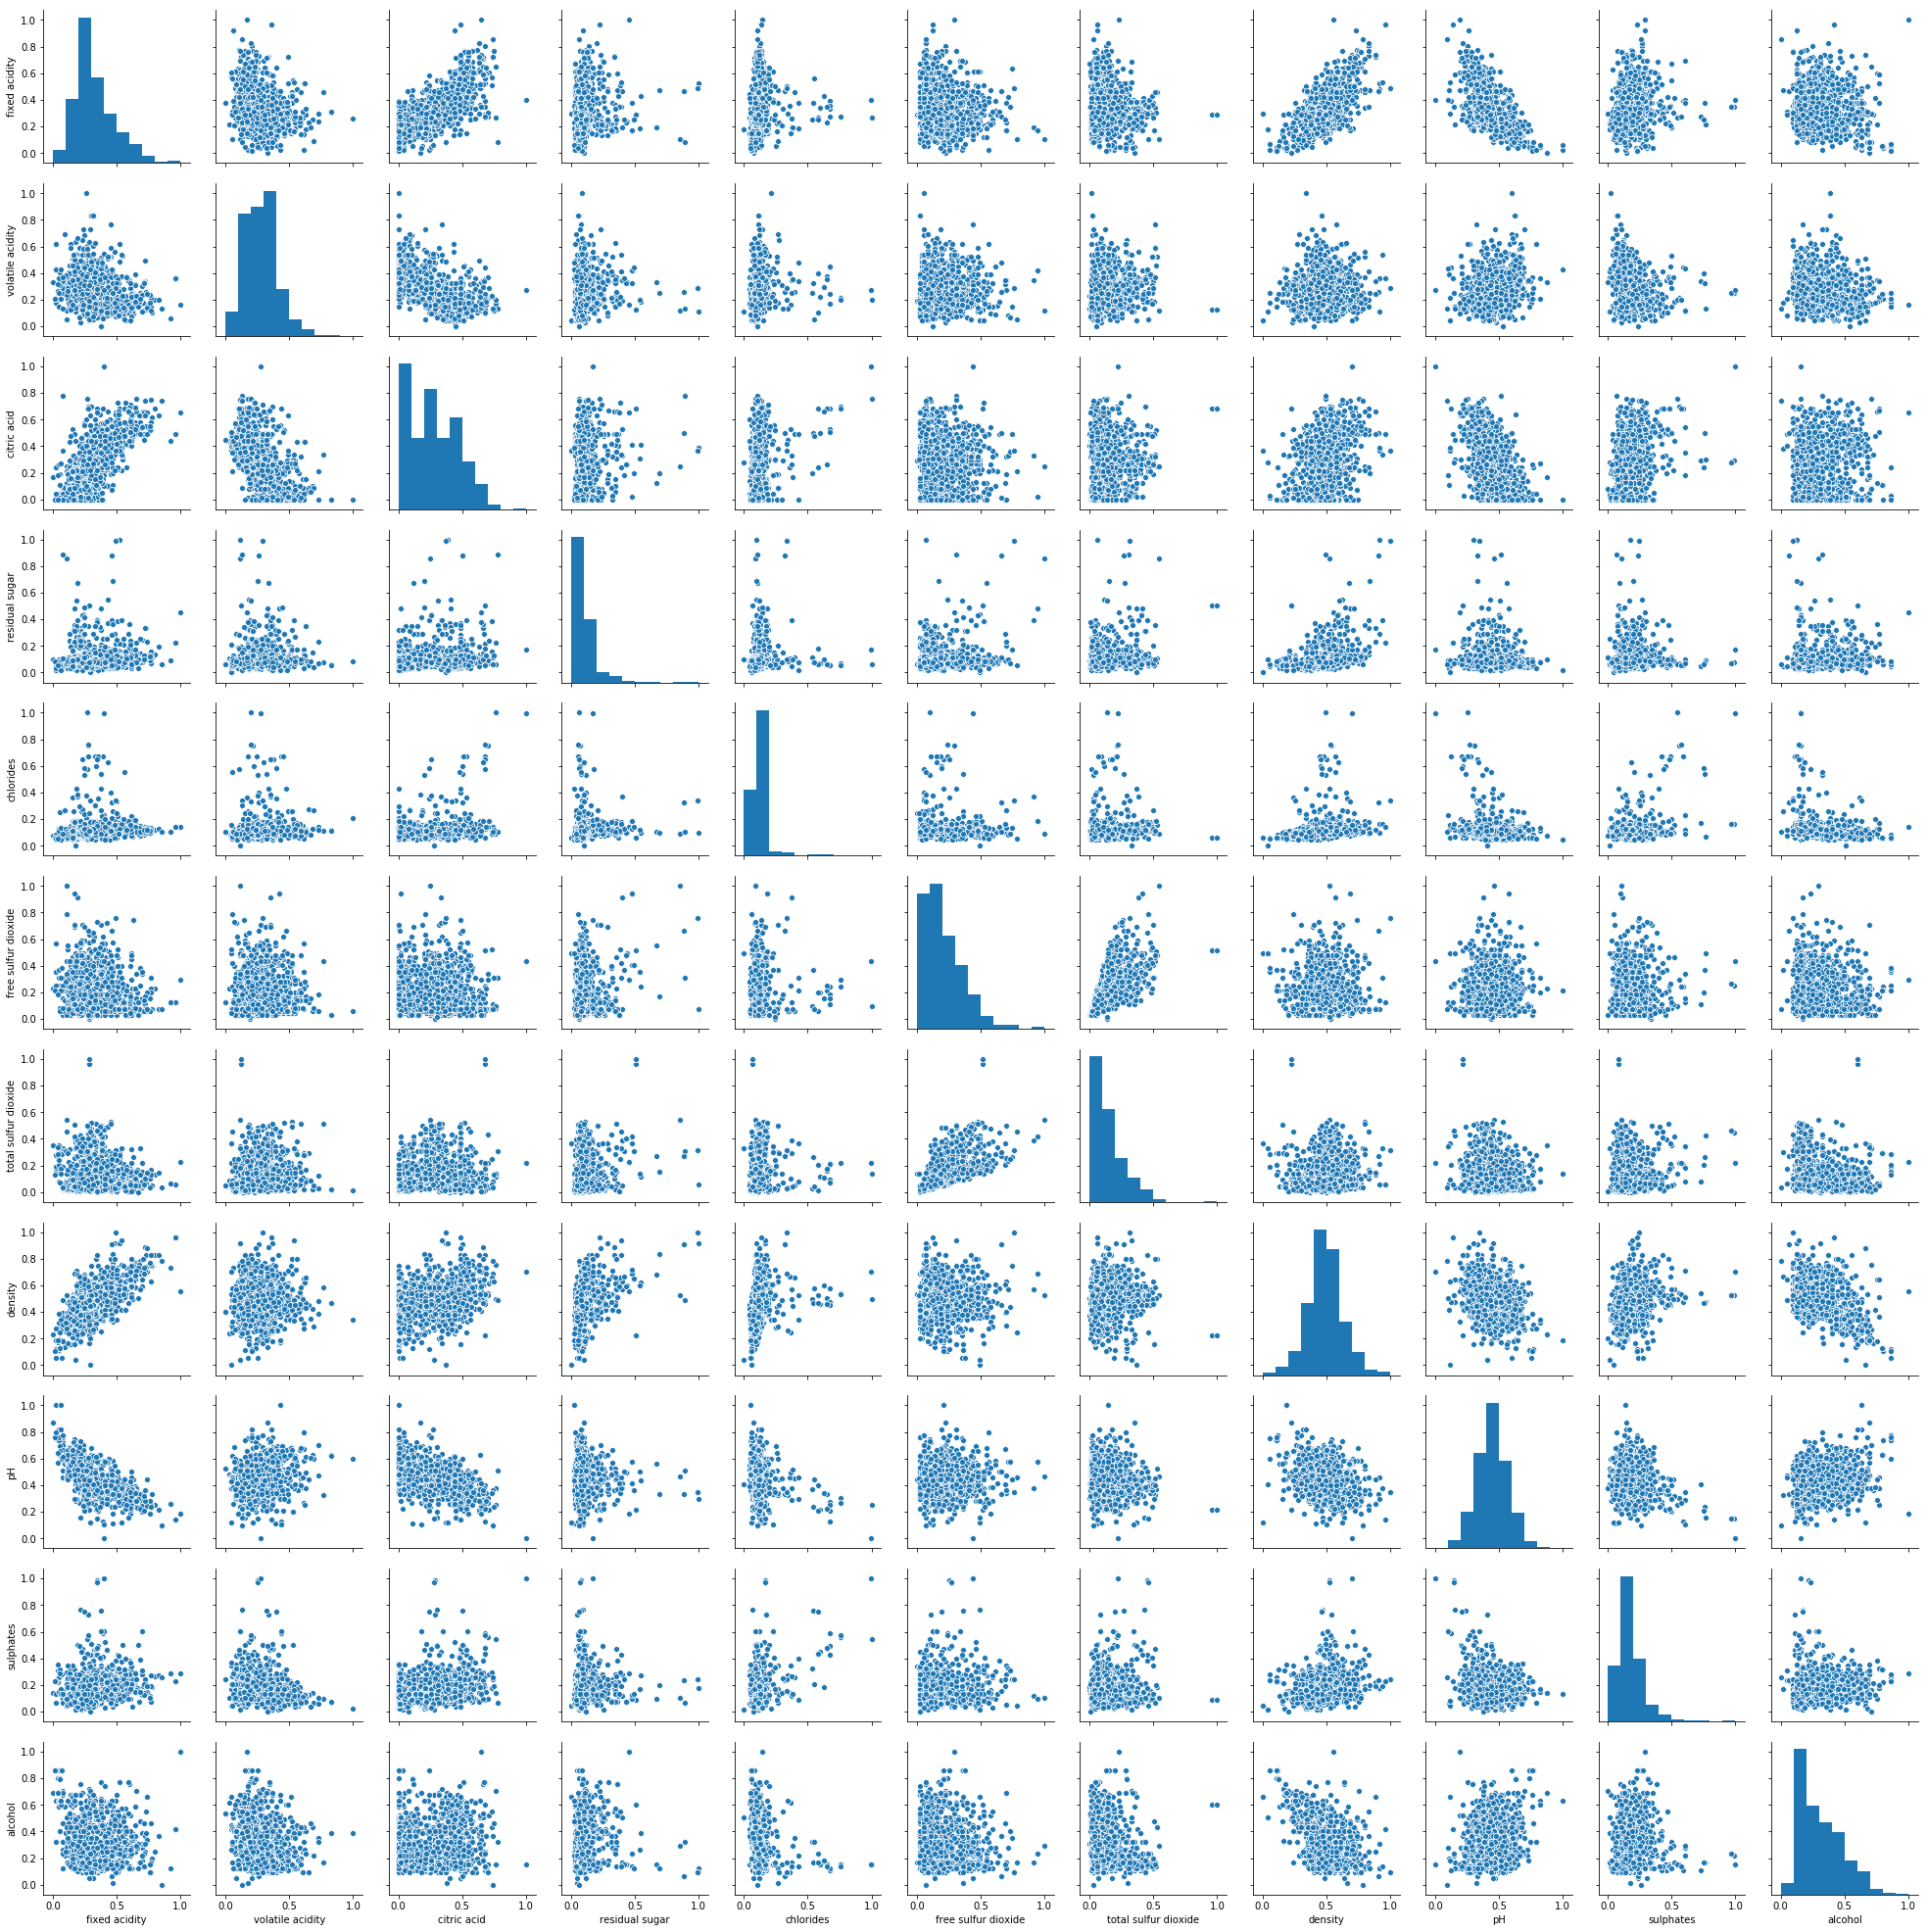

In [19]:
# 散布図行列を表示
sns.pairplot(X_train)

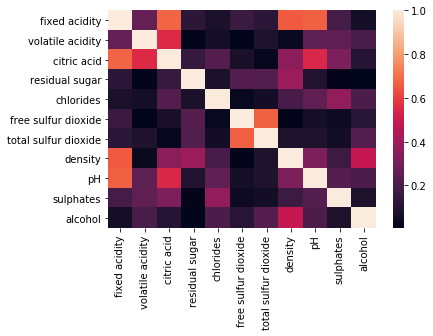

In [20]:
# 相関係数行列とヒートマップ
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix.abs())

In [22]:
corr_matrix.abs().sum().sort_values(ascending=False)

citric acid             4.025635
fixed acidity           3.996454
pH                      3.712360
density                 3.712359
sulphates               2.716379
volatile acidity        2.710874
alcohol                 2.692520
total sulfur dioxide    2.616399
chlorides               2.548287
free sulfur dioxide     2.387581
residual sugar          2.316934
dtype: float64

In [368]:
# 目的変数と各特徴量間の相関係数
corr_y = pd.Series([X_train[col].corr(y_train) for col in X_train.columns], index=X_train.columns)

In [369]:
corr_y.abs().sort_values(ascending = False)

alcohol                 0.056532
density                 0.038151
residual sugar          0.029702
pH                      0.026990
free sulfur dioxide     0.024251
volatile acidity        0.023693
total sulfur dioxide    0.015429
chlorides               0.010048
citric acid             0.008131
sulphates               0.006910
fixed acidity           0.006903
dtype: float64

予想通りと言って良いのかわからないが、他の説明変数との相関が強い特徴量は目的変数との相関が弱い傾向にあるように見える。

fixed acidity は、citric acid, density, pH との相関が高く、目的変数との相関も低いため明らかに排除して良さそう

他はひとまず保留

In [370]:
del_columns = pd.Index(["fixed acidity"])

In [371]:
X_train = X_train.drop(del_columns, axis=1)
X_test = X_test.drop(del_columns, axis=1)

In [372]:
for col in del_columns:
    feature_names.remove(col)

## スコア

In [373]:
cross_validation(svm_clf)

Cross-Validation scores: [0.54910714 0.50892857 0.51785714 0.54910714 0.4573991 ]
Average score: 0.5164798206278027
Test score: 0.5333333333333333


In [374]:
cross_validation(svm_reg)

Cross-Validation scores: [0.45557564 0.42602816 0.388447   0.42808189 0.34837857]
Average score: 0.4093022514445309
Test score: 0.44300890117530456


## 結論
Test scoreに対する結果は悪化した。目的変数への相関が0.01未満の列を全て削って見ても若干の悪化が見られたため、特徴量の削減によってスコアの向上は望めなそうな気がする。

行ったことを振り返ってみると正規化の作業以外で生産性のあることが残念。